In the name of God  

# RWP

In [1]:
#Import library 
from pymobility.models.mobility import random_waypoint

In [2]:
rw = random_waypoint(12, dimensions=(500, 500), velocity=(5.0, 5.0), wt_max=1000.0)

In [ ]:
positions = next(rw)
positions

In [ ]:
for positions in rw:
    print(positions)

In [3]:
import numpy as np
from math import log as ln
from math import sin,cos,pi,sqrt,atan,log2,exp,pow,log10
class LiFiAccessPoint:
    def __init__(self,x,y):
        self.x      = x                 # horizontal position of WiFi AP
        self.y      = y                 # vertical position of LiFi AP
        self.N_LiFi = pow(10,(-21))     # LiFi noise power spectral density 
        self.B_LiFi = 40*10e6           # LiFi bandwidth (Hz)
        self.P_opt = 3                  # Optical power (watt)
        self.R     = 0.53               # Responsivity (A/W)
        self.scale = 100
    def calculate_distance(self,user_position):
        return sqrt( pow((self.x-user_position[0]),2) + pow((self.y-user_position[1]),2) ) / self.scale


    def phi(self,user_position): # Angle between user-to-lifi access point with room vertical orthogonal line
        h = 2                                       # Room height (m)
        d = self.calculate_distance(user_position)
        return atan( d / h)
    
    def g_c(self,psi): # Gain of optical concentrator
        self.PSI_MAX    = pi/4  # Semi-angle of field of view (radian)
        n               = 1.5   # Refractive index
        if 0 <= psi and psi <= self.PSI_MAX:
            return pow(n,2)/pow(sin(psi),2)
        else:
            return 0

    def H_LOS(self,user_position): # Line of sight channel coefficient
        led_half_pi= pi/3                                   # LED field of view (radian)
        m          = -ln(2)/ln(cos(led_half_pi))            # lambertian order
        A_PD       = 1                                      # Area of photodetector (cm^2)
        g_f        = 1                                      # Optical filter gain
        phi        = self.phi(user_position=user_position)
        g_c        = self.g_c
        d          = self.calculate_distance(user_position)
        return ( (m+1)*A_PD*cos(phi)*g_f*g_c(phi)*cos(phi) ) / (2*pi*pow(d,2))

    def H_LiFi(self,user):
        return self.H_LOS(user.position) 

    def SNR(self,user): # Signal to noise ratio
        return ( pow((self.H_LiFi(user)*self.P_opt*self.R),2) ) / (self.N_LiFi*self.B_LiFi)

    def SINR(self,user,other_LiFi_AP): # Signal to interference noise ratio 
        interference = 0 
        for i in other_LiFi_AP: 
            interference += i.H_LiFi(user)*i.P_opt*i.R
        return ( pow((self.H_LiFi(user)*self.P_opt*self.R),2) ) / (self.N_LiFi*self.B_LiFi + interference)


    def r(self,user,other_LiFi_AP): # Achievable rate
        return (self.B_LiFi/2)*log2(1+(6/(pi*exp(1)))*self.SINR(user,other_LiFi_AP)) 

class WiFiAccessPoint:
    def __init__(self,x,y):
        self.x      = x
        self.y      = y
        self.scale  = 100

    def calculate_distance(self,user_position):
        return sqrt( pow((self.x-user_position[0]),2) + pow((self.y-user_position[1]),2) ) / self.scale

    def L_FS(self,d):
        f_c = 2.4 # Carrier frequency
        return 20*log10(d)+20*log10(f_c)-147.5
    def L(self,d,user_position):                        # Large scale fading
        d_BP = 0.05                                     # Breakpoint distance (m)
        d    = self.calculate_distance(user_position)
        X_SF = 3                                        # Shadowing loss (dB)
        if d < d_BP:
            return self.L_FS(d)+X_SF
        else:
            return self.L_FS(d_BP)+35*log10(d/d_BP)+X_SF

    def G(self,user):
        h_r_db_average_power    = 2.46
        h_r_db                  = np.random.rayleigh(h_r_db_average_power, 1) 
        h_r                     = pow(10,h_r_db/10)
        d                       = self.calculate_distance(user.position)
        return sqrt(pow(10,-1*self.L(d,user.position)/10))*h_r
    
    def SINR(self,user):
        P_T     = 0.1                   # Transmit power (Watt)
        N_WiFi  = 3.98107*pow(10,-21)   # PSD of noise 
        B_WiFi  = 20e6                    # Bandwidth (Hz)
        return (self.G(user)*P_T) / (N_WiFi*B_WiFi)


class User:
    def __init__(self,number,position):
        self.position = position
        self.number = number

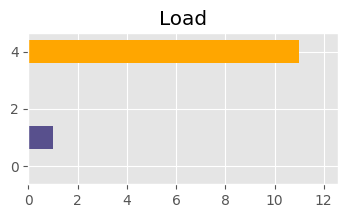

In [34]:
from tkinter import *
from time import time, sleep
from PIL import Image,ImageTk
import math
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd

canvas_width            = 500
canvas_height           = 500
actual_room_width       = 5 #(m)
actual_room_height      = 5 #(m)
main_window_resolution  = "1920x1080"
scale = 500 / 500

# dimension of users
rectangle_width = 10
rectangle_height = 10


N_USER          = 12                                             # Number of users
N_LiFi_AP       = 4                                             # Number of LiFi access point
N_WiFi_AP       = 1                                             # Number of WiFi access point


LiFi_AP_coordinate = [[125,125],[125,375],[375,125],[375,375]] 
WiFi_AP_coordinate = [[250,250]]
# def paint(event):
#     python_green = "#476042"
#     x1, y1 = (event.x - 1), (event.y - 1)
#     x2, y2 = (event.x + 1), (event.y + 1)
#     w.create_oval(x1, y1, x2, y2, fill=python_green)

def showMovement():
        global position

        for i in range(N_USER):
                x1 = position[i][0]
                y1 = position[i][1]
                position=next(rw)
                x2 = position[i][0]
                y2 = position[i][1]
                dx = x2 - x1
                dy = y2 - y1
                w.move(users[i],dx*scale,dy*scale)
                w.move(user_labels[i],dx*scale,dy*scale)
                user_objects[i].position = w.coords(users[i])
        calculate_snr(LiFi_APs,WiFi_APs,user_objects)
        
        w.after(50,showMovement)


def calculate_snr(LiFi_APs,WiFi_APs,users):
        global SNRs
        global BarChartData

        SNRs = np.zeros((N_USER,N_LiFi_AP+N_WiFi_AP))
        temp = []
        BarChartData = np.zeros((N_LiFi_AP+N_WiFi_AP))
        for i in range(N_USER):
                for j in range(N_LiFi_AP):
                        other_LiFi_AP = [value["LiFi_AP_obj"] for index, value in enumerate(LiFi_APs) if index != j]
                        SNRs[i][j] = LiFi_APs[j]["LiFi_AP_obj"].SINR(user_objects[i],other_LiFi_AP)
                for j in range(len(WiFi_APs)):
                        SNRs[i][j+N_LiFi_AP] = WiFi_APs[j]["WiFi_AP_obj"].SINR(user_objects[i])
                w.itemconfig(user_labels[i], text=(np.argmax(SNRs[i])), font=('Helvetica 12 bold'),fill="white")
                temp.append(np.argmax(SNRs[i]))

        for k in range(N_LiFi_AP+N_WiFi_AP):
                BarChartData[k] = temp.count(k)
        
        
        
def plotLoadBar(i):
        global barplot
        barplot.remove()
        barplot = ax1.barh(range(N_LiFi_AP+N_WiFi_AP),BarChartData,color=['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'])   
        
        

master = Tk()
# master = Toplevel()
# master.geometry(main_window_resolution)
master.title("Room")
master.configure(bg="black")

w = Canvas(master,
           width=canvas_width,
           height=canvas_height,background="black")
w.pack(expand=YES, fill=BOTH)

style.use('ggplot')
figure1 = plt.figure(figsize=(4,2), dpi=100)
ax1 = figure1.add_subplot(111)
bar1 = FigureCanvasTkAgg(figure1, master)
bar1.get_tk_widget().pack()
ax1.set_title('Load')

barplot = ax1.barh(range(N_LiFi_AP+N_WiFi_AP),BarChartData)

# df1 = pd.DataFrame(BarChartData)
# df1.plot(kind='bar', legend=True, ax=ax1)


ani = animation.FuncAnimation(figure1,plotLoadBar,interval=50,blit=False)

# w.pack()

position = next(rw)
users=[]
user_objects=[]
user_labels=[]
LiFi_APs=[]
WiFi_APs=[]
# for n in range(Nu):
#     users.append(w.create_rectangle(position[n][0]*scale,position[n][1]*scale,
#                     position[n][0]*scale+rectangle_width,
#                     position[n][1]*scale+rectangle_height,fill='blue'))

colors=['blue','green','red','yellow','orange','white','blue','green','red','yellow','orange','white']

for n in range(N_USER):
        users.append(w.create_oval(position[n][0]*scale,position[n][1]*scale,
                    position[n][0]*scale+rectangle_width,
                    position[n][1]*scale+rectangle_height,fill=colors[n])
                    )
        user_objects.append(User(n,w.coords(users[n])))
        # if(position[n][0]-rectangle_width >= 0 and position[n][1]-rectangle_height >= 0):
        user_labels.append(w.create_text(position[n][0]-rectangle_width, position[n][1]-rectangle_height, text="HELLO WORLD", fill="black", font=('Helvetica 15 bold')))
        # else:
        #         user_labels.append(w.create_text(0, 0, text="", fill="black", font=('Helvetica 5 bold')))

                
LiFi_AP_img = Image.open("./images/LiFiAP.png")
LiFi_AP_Image_width  = 45
LiFi_AP_Image_height = 45
LiFi_AP_img = LiFi_AP_img.resize((LiFi_AP_Image_width,LiFi_AP_Image_height),Image.ANTIALIAS)
LiFi_AP_img = ImageTk.PhotoImage(LiFi_AP_img)

WiFi_AP_img = Image.open("./images/WiFiAP.png")
WiFi_AP_image_width  = 32
WiFi_AP_image_height = 32
WiFi_AP_img = WiFi_AP_img.resize((WiFi_AP_image_width,WiFi_AP_image_height),Image.ANTIALIAS)
WiFi_AP_img = ImageTk.PhotoImage(WiFi_AP_img)

scale_x = canvas_width/actual_room_width
scale_y = canvas_width/actual_room_height

for i in range(N_LiFi_AP):
        x = LiFi_AP_coordinate[i][0]
        y = LiFi_AP_coordinate[i][1]
        LiFi_APs.append({"LiFi_AP_image": w.create_image(x-LiFi_AP_Image_width/2,y-LiFi_AP_Image_height/2,anchor=NW,image=LiFi_AP_img) , "LiFi_AP_obj" : LiFiAccessPoint(x,y)})

for i in range(N_WiFi_AP):
        x = WiFi_AP_coordinate[i][0]
        y = WiFi_AP_coordinate[i][1]
        WiFi_APs.append({"WiFi_AP_image": w.create_image(x-WiFi_AP_image_width/2,y-WiFi_AP_image_width/2,anchor=NW,image=WiFi_AP_img) , "WiFi_AP_obj" : WiFiAccessPoint(x,y)})

w.after(50,showMovement)
# w.after(50,plotLoadBar)

mainloop()    

In [ ]:
from math import log as ln
from math import pi

In [ ]:
class test:
    def __init__(self):
        self.m = 3

test().m

In [ ]:
temp=[1,2,3,3]
temp.count(3)


In [ ]:
colors.__len__()